In [18]:
import argparse
import json
import os
import re
import cv2
import h5py
import numpy as np
import tifffile
from ScanImageTiffReader import ScanImageTiffReader
from scipy.ndimage import gaussian_filter, median_filter, shift, uniform_filter1d
from scipy.signal import convolve
from tqdm import tqdm

In [19]:
!pip install matplotlib
import matplotlib.pyplot as plt

from dataclasses import dataclass, field

@dataclass
class SimulationParameters:
    input: str
    output: str = "../results/"
    SimDescription: str = "default"
    darkrate: float = 0.02
    IMsz: list = field(default_factory=lambda: [45, 125])
    frametime: float = 0.0023
    brightness: float = 0.2
    bleachTau: int = 360
    T: int = 10000
    motionAmp: float = 3
    tau: float = 0.027
    activityThresh: float = 0.12
    sigma: float = 1.33
    photonScale: int = 600
    nsites: int = 30
    minDistance: float = 1.5
    minspike: float = 0.3
    maxspike: float = 4.0
    spikeAmp: int = 2
    numTrials: int = 1
    writetiff: bool = True

args = SimulationParameters(input="/data/zstacks/scan_00001-REF_Ch2.ome.tif")
params = vars(args)

In [20]:
fn, output_path, seed= args.input, args.output, 0

In [39]:
def sim_motion(seed, old=True):
    np.random.seed(seed)    
    envelope = np.sin(np.cumsum(np.random.randn(params["T"]) / 20))**2
    motionPCs = [np.convolve(
        np.multiply(
            envelope,
            np.sin(
                np.convolve(
                    np.random.randn(params["T"]) ** 3,
                    np.ones(40) / 40,
                    mode="same",
                )
                / 10
            ) if old else
            np.convolve(
                    np.random.randn(params["T"]) ** 5,
                    np.ones(40) / 40,
                    mode="same",
                )
                / 10
            ,
        ),
        np.ones(5) / 5,
        mode="same",
    ) for _ in range(3)]

    psi, theta, phi = np.pi * np.random.rand(3)

    R = (
        np.array(
            [
                [np.cos(psi), -np.sin(psi), 0],
                [np.sin(psi), np.cos(psi), 0],
                [0, 0, 1],
            ]
        )
        @ np.array(
            [
                [np.cos(theta), 0, np.sin(theta)],
                [0, 1, 0],
                [-np.sin(theta), 0, np.cos(theta)],
            ]
        )
        @ np.array(
            [
                [1, 0, 0],
                [0, np.cos(phi), -np.sin(phi)],
                [0, np.sin(phi), np.cos(phi)],
            ]
        )
    )

    motion = R @ np.array(motionPCs)

    motion *= np.array([[1], [0.25], [0.15]])  # TODO: May need to fine tune for Z motion
    # center & normalize
    motion -= motion.mean(-1)[:, None]
    motion *= params['motionAmp'] / np.sqrt(np.mean(np.sum(motion**2, 0)))
    return motion

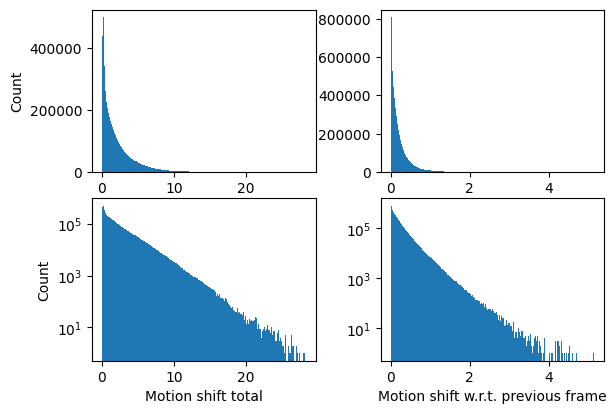

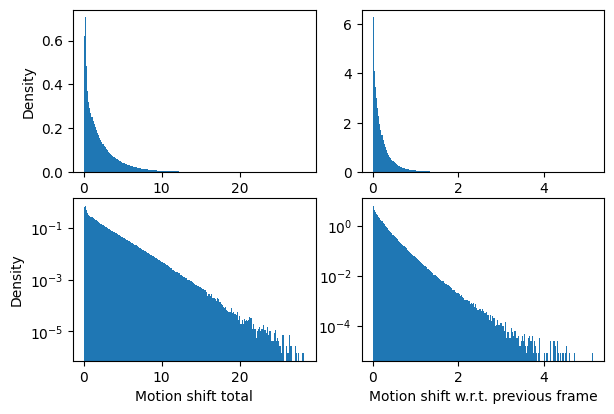

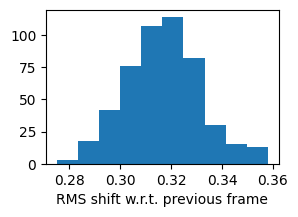

In [40]:
motion = np.array([sim_motion(seed) for seed in range(500)])

def calc_shifts(key="total"):
    if key=="total":
        sq = (motion - motion.mean(-1)[..., None])**2
    else:
        sq = np.diff(motion, axis=-1)**2
    return np.sqrt(sq.sum(1))

for density in (False, True): 
    plt.figure(figsize=(6,4))
    for key in ("total", "w.r.t. previous frame"):
        shifts=calc_shifts(key=key)
        for log in (0,1):
            plt.subplot(2,2,(1 if key=="total" else 2)+2*log)
            plt.hist(shifts.ravel(), 200, log=log, density=density)
            if log:
                plt.xlabel(f"Motion shift {key}")
            if key=="total":
                plt.ylabel("Density" if density else "Count") 
    plt.tight_layout(pad=.2)

plt.figure(figsize=(3,2))
plt.hist(np.sqrt(np.mean(shifts**2,1)), 10)
plt.xlabel("RMS shift w.r.t. previous frame");

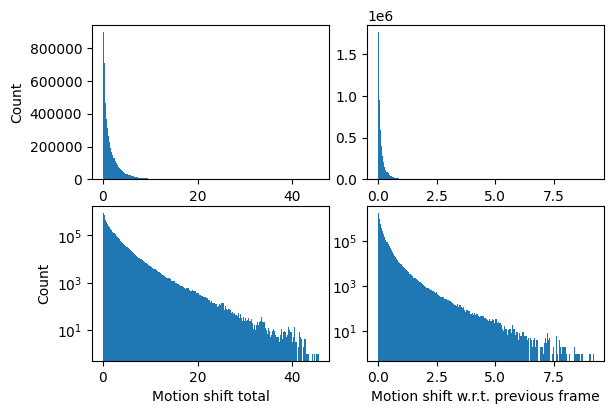

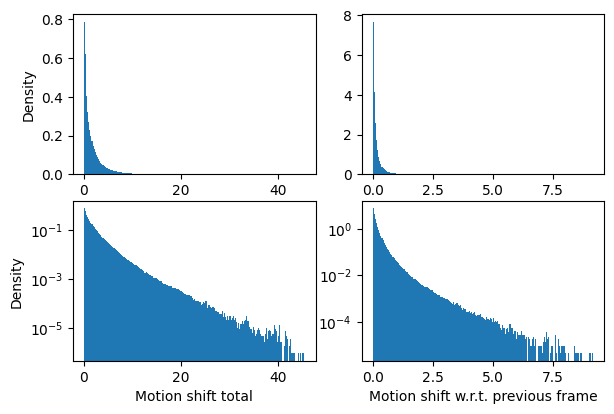

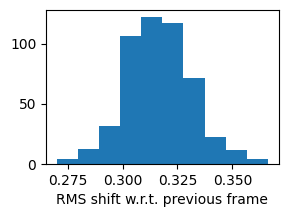

In [41]:
motion = np.array([sim_motion(seed, False) for seed in range(500)])

def calc_shifts(key="total"):
    if key=="total":
        sq = (motion - motion.mean(-1)[..., None])**2
    else:
        sq = np.diff(motion, axis=-1)**2
    return np.sqrt(sq.sum(1))

for density in (False, True): 
    plt.figure(figsize=(6,4))
    for key in ("total", "w.r.t. previous frame"):
        shifts=calc_shifts(key=key)
        for log in (0,1):
            plt.subplot(2,2,(1 if key=="total" else 2)+2*log)
            plt.hist(shifts.ravel(), 200, log=log, density=density)
            if log:
                plt.xlabel(f"Motion shift {key}")
            if key=="total":
                plt.ylabel("Density" if density else "Count") 
    plt.tight_layout(pad=.2)

plt.figure(figsize=(3,2))
plt.hist(np.sqrt(np.mean(shifts**2,1)), 10)
plt.xlabel("RMS shift w.r.t. previous frame");

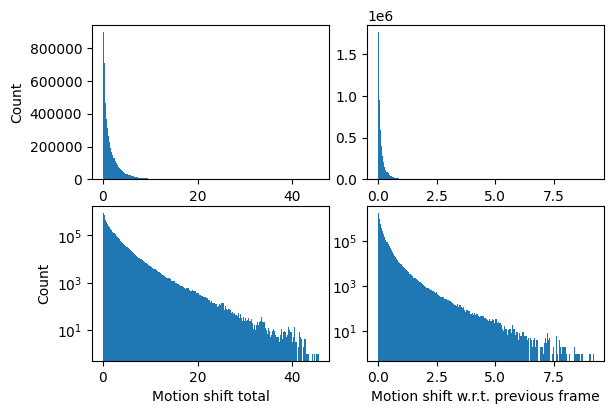

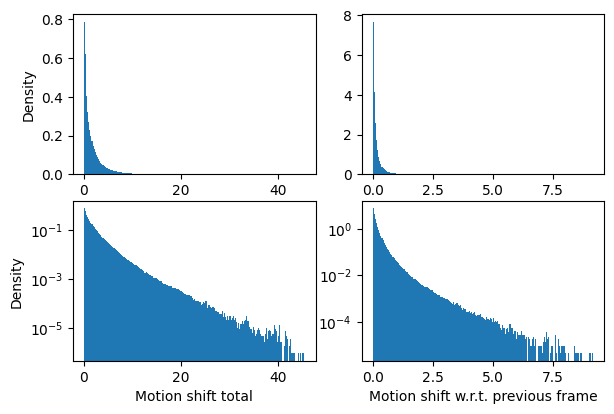

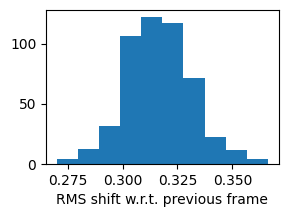

In [ ]:
motion = np.array([sim_motion(seed, False) for seed in range(500)])

def calc_shifts(key="total"):
    if key=="total":
        sq = (motion - motion.mean(-1)[..., None])**2
    else:
        sq = np.diff(motion, axis=-1)**2
    return np.sqrt(sq.sum(1))

for density in (False, True): 
    plt.figure(figsize=(6,4))
    for key in ("total", "w.r.t. previous frame"):
        shifts=calc_shifts(key=key)
        for log in (0,1):
            plt.subplot(2,2,(1 if key=="total" else 2)+2*log)
            plt.hist(shifts.ravel(), 200, log=log, density=density)
            if log:
                plt.xlabel(f"Motion shift {key}")
            if key=="total":
                plt.ylabel("Density" if density else "Count") 
    plt.tight_layout(pad=.2)

plt.figure(figsize=(3,2))
plt.hist(np.sqrt(np.mean(shifts**2,1)), 10)
plt.xlabel("RMS shift w.r.t. previous frame");